# SCA 2024 - Sustainability Championship of America 2024

- Fabian Hildebrandt
- Matriculation Number: 23392857
- Email: fabian.hildebrandt@fau.de

## Visualization checks

1. Identify and install a good library for map visualizations - GeoPandas
2. Load examplary indicator and visualize the data for the latest date
3. Fine-tune the visualization

## ToDo

- add the countries dataset to the pipeline: **Natural Earth**, [Natural Earth](https://www.naturalearthdata.com)
- [Link to dataset](https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip)
- [Terms of use](https://www.naturalearthdata.com/about/terms-of-use/)

In [1]:
# import the necessary packages
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
# import seaborn as sns
import geopandas as gpd
import os 
import yaml
import pandas as pd
import sqlite3


# world = gpd.read_file()

# geodataset_path = ("https://www.naturalearthdata.com/"\
#               "http//www.naturalearthdata.com/download/"\
#               "10m/cultural/ne_10m_admin_0_countries.zip"
#              )

# geodataset_path = 'https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip'

geodataset_path = 'test.shp'

countries = gpd.read_file(geodataset_path)

with open('./config.yaml', 'r', encoding='utf-8') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)



# americas = countries[countries['CONTINENT'].isin(['North America', 'South America'])]
# # country_list = ['IDN', 'MYS']

# filtered_countries = countries[americas["ISO_A3"].isin(country_list)]

# filtered_countries.plot()

# Step 1: Filter countries by continent
filtered_countries = countries[countries['CONTINENT'].isin(['North America', 'South America'])]
# americas = countries[countries['CONTINENT'].isin(['South America'])]

# Step 2: Define the country list to filter within the Americas
country_list = list(config['countries'].values())

# Step 3: Filter the Americas dataset for the countries in the list
filtered_countries = filtered_countries[filtered_countries["WB_A3"].isin(country_list)]

print(f'Extracted {len(filtered_countries)} countries')
# print(filtered_countries['WB_A3'])
# excluded_countries = country_list[country_list.isin(list(filtered_countries['WB_A3']))]
excluded_countries = [country for country in country_list if country not in list(filtered_countries['WB_A3'])]
print(f'Following countries were not found: {excluded_countries}')

filtered_countries.reset_index(drop=True)
filtered_countries.set_index('WB_A3', inplace=True)

print(filtered_countries.loc['CAN'])


DataSourceError: test.shp: No such file or directory

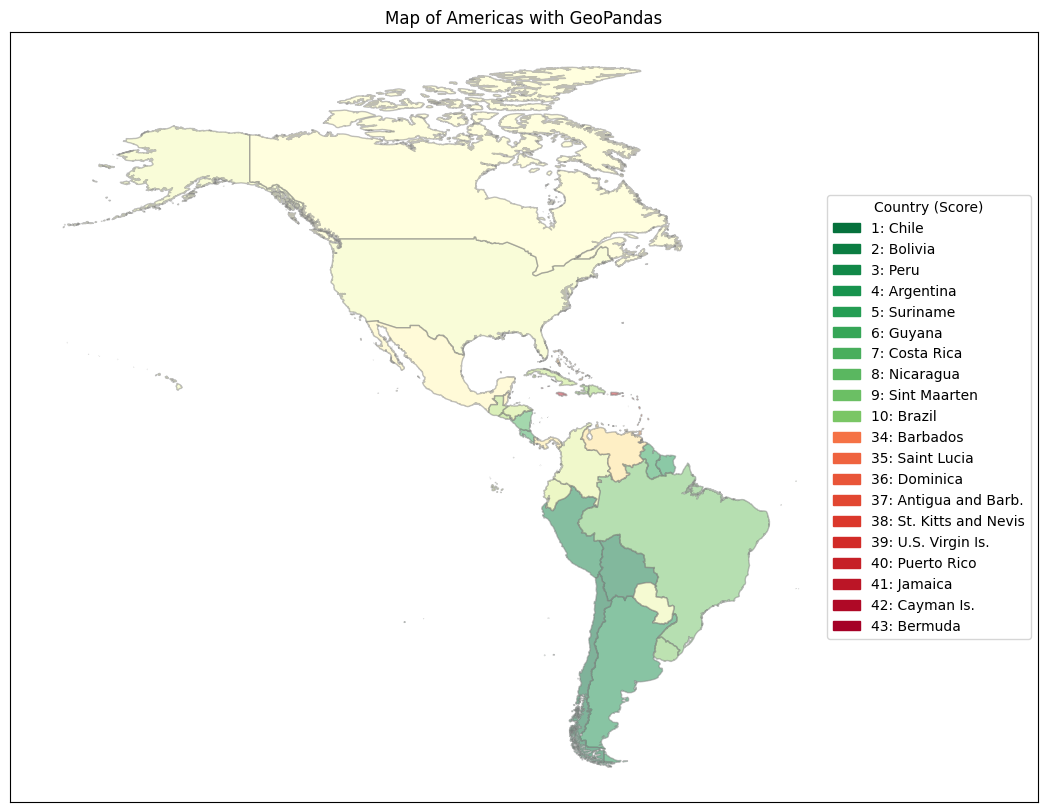

In [56]:
# Step 4: Plot the filtered countries
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
numbers = list(range(1,len(country_list)+1))
filtered_countries['score'] = numbers
filtered_countries = filtered_countries.sort_values(by='score', ascending=True)

top_10 = filtered_countries[['NAME', 'score']].head(10)
bottom_10 = filtered_countries[['NAME', 'score']].tail(10)
countries_of_interest = pd.concat([top_10, bottom_10])

filtered_countries.plot(column='score', cmap = 'RdYlGn_r', ax = ax, alpha = 0.5, edgecolor='grey', legend=False)

# Step 2: Prepare the custom legend
# Create a dictionary mapping scores to names
score_to_name = dict(zip(countries_of_interest['score'], countries_of_interest['NAME']))

# Create legend handles
legend_handles = [
    mpatches.Patch(color=color, label=f"{score}: {name}")
    for score, name, color in zip(
        countries_of_interest['score'], 
        countries_of_interest['NAME'], 
        plt.cm.RdYlGn_r(countries_of_interest['score'] / max(countries_of_interest['score']))  # Normalize scores
    )
]

ax.set_xlim(left=-190, right=20)
# Step 3: Add the custom legend
ax.legend(handles=legend_handles, title="Country (Score)", loc='center right', fontsize='medium')

# turn off axis ticks
ax.set_xticks([])
ax.set_yticks([])

# set the plot title
plt.title("Map of Americas with GeoPandas")
plt.show()


In [59]:
filtered_countries[filtered_countries['WB_A3'] == 'USA']['score'] = None

KeyError: 'WB_A3'

In [68]:

# Define database path and parameters
db_path = '../data/owid.sqlite'
assert os.path.exists(db_path), "SQLite database should be created"

countries_query = ('CAN', 'USA', 'MEX')
indicator = "'population'"
year_range = (2000, 2005)
high_values_rank_first = False

# SQL query to fetch data
query = f"""
SELECT * 
FROM indicator_data 
WHERE country IN {countries_query} 
AND indicator = {indicator} 
AND year BETWEEN {year_range[0]} AND {year_range[1]}
"""

# Fetch data from SQLite
with sqlite3.connect(db_path) as conn:
    data = pd.read_sql_query(sql=query, con=conn).reset_index(drop=True)

    # Ensure data is sorted by country and year
    data = data.sort_values(by=['country', 'year'])

    # Group data by country and calculate the annual rate of change
    def calculate_rate_of_change(group):
        # Ensure no gaps in years
        group['year_diff'] = group['year'].diff().fillna(0)
        group = group[group['year_diff'] == 1]  # Only consecutive years
        # Calculate rate of change
        group['rate_of_change'] = group['value'].pct_change() * 100
        return group.reset_index()

    # Apply rate of change calculation for each country
    data_with_change = data.groupby('country').apply(calculate_rate_of_change)
    data_with_change = data_with_change.reset_index(drop=True)

    # Calculate average rate of change for each country
    data_with_change_avg = data_with_change.groupby('country')['rate_of_change'].mean()

    # Create a DataFrame with rankings based on rate_of_change
    ranking_rate_of_change = data_with_change_avg.rank(ascending=high_values_rank_first, method='average').astype(int)
    ranking_df = pd.DataFrame({
        'country': ranking_rate_of_change.index,
        'ranking': ranking_rate_of_change.values
    }).sort_values(by='ranking')

    # Display final rankings
    print("Country rankings based on rate of change:")
    print(data_with_change_avg)
    print(ranking_df)

Country rankings based on rate of change:
country
CAN    0.968275
MEX    1.397139
USA    0.990964
Name: rate_of_change, dtype: float64
  country  ranking
1     MEX        1
2     USA        2
0     CAN        3


/var/folders/wl/bqltr__102vd9lk4m22xks5c0000gn/T/ipykernel_27787/1860447061.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_with_change = data.groupby('country').apply(calculate_rate_of_change)


In [73]:
# max normalization
normalized_ranking = ranking_df.copy(deep=True)
normalized_ranking['ranking'] = normalized_ranking['ranking'] / normalized_ranking['ranking'].max()
print(normalized_ranking)

  country   ranking
1     MEX  0.333333
2     USA  0.666667
0     CAN  1.000000


In [10]:
# Rank function
data = pd.DataFrame(data={'Animal': ['cat', 'penguin', 'dog',
                                   'spider', 'snake'],
                        'Number_legs': [4, 2, 4, 8, 0]})
data = data.rank(ascending=True).astype('int16')
print(data)

   Animal  Number_legs
0       1            3
1       3            2
2       2            3
3       5            5
4       4            1


## Query the total emissions from OWID

In [19]:
# Define database path and parameters
db_path = '../data/owid.sqlite'
assert os.path.exists(db_path), "SQLite database should be created"

indicator = "'co2'"
year_range = (2021, 2022)
high_values_rank_first = False

# SQL query to fetch data
query = f"""
SELECT * 
FROM indicator_data 
WHERE indicator = {indicator} 
AND year =2022
"""

# Fetch data from SQLite
with sqlite3.connect(db_path) as conn:
    data = pd.read_sql_query(sql=query, con=conn).reset_index(drop=True)

    # Ensure data is sorted by country and year
    data = data.sort_values(by=['country', 'year'])

    data = data.groupby('country')['value'].mean().sort_values(ascending=True)
    largest_5_emissions = data.tail(5).values.sum()
    total_emissions = data.values.sum()
    percentage_largest_5 = largest_5_emissions / total_emissions

    results = f"""
    Emissions of largest 5 economies: {largest_5_emissions:.2f}
    Total emissions: {total_emissions:.2f}
    Percentage: {percentage_largest_5:.2f}
    Percentage US: {(data['USA']/ total_emissions):.2f}
    Country overview:\n{data}
    """
    print(results)


    Emissions of largest 5 economies: 6782.74
    Total emissions: 7362.51
    Percentage: 0.92
    Percentage US: 0.69
    Country overview:
country
DMA       0.156
KNA       0.224
VCT       0.227
GRD       0.321
TCA       0.355
LCA       0.490
BMU       0.501
ATG       0.618
BLZ       0.632
SXM       0.664
ABW       0.831
BRB       1.143
CUW       1.940
BHS       2.402
SUR       2.640
HTI       3.381
GUY       3.627
NIC       5.296
JAM       7.137
SLV       7.800
URY       7.820
CRI       7.847
PRY       8.107
HND      10.482
PAN      11.356
GTM      19.114
CUB      21.882
BOL      22.378
DOM      30.431
TTO      36.306
ECU      40.522
PER      54.793
CHL      82.537
VEN      87.515
COL      98.293
ARG     204.081
MEX     465.336
BRA     483.841
CAN     550.612
USA    5078.871
Name: value, dtype: float64
    
